In [1]:
# Set the stage
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [75]:
def get_images_from_folder(images_path):
  return [np.array(Image.open(image_name)) for image_name in os.listdir(images_path) if 'jpg' in image_name.lower()]

def get_images_from_video(video_path):
  cam = cv2.VideoCapture(video_path)

  images = []
  while True: 
    ret,frame = cam.read()

    if not ret:
      break
    
    images.append(np.array(frame))
  cam.release()
  return images

def store_video_from_images(images, videoname="video"):
  h, w, c = images[0].shape
  size = (w, h)

  out = cv2.VideoWriter(videoname+'.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, size)
  for image in images:
      out.write(image)
  cv2.destroyAllWindows()
  out.release()

def get_segmentations(images):
  segmentations = []
  for i in tqdm(range(len(images))):
    input_image = images[i]
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]

    output_predictions = output.argmax(0)
    segmentations.append(np.array(output_predictions))
  return segmentations

def mask_image(image, segmentation, countours=True):
  np_seg = np.array(segmentation)
  np_img = np.array(image)

  w, h, c = np_img.shape
  new_image = np.zeros((w,h,c))

  if countours:
    countours_image = cv2.Canny(image, 100, 200)

  for row in range(w):
    for col in range(h):
      if np_seg[row][col] != 0:
        new_image[row][col][:] = np_img[row][col][:]
      elif countours:
        if countours_image[row][col] != 0:
          new_image[row][col][:] = 255
  return new_image.astype('uint8')

100%|██████████| 1/1 [00:07<00:00,  7.80s/it]


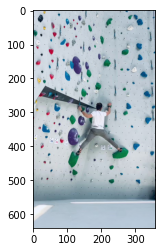

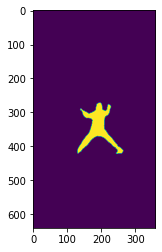

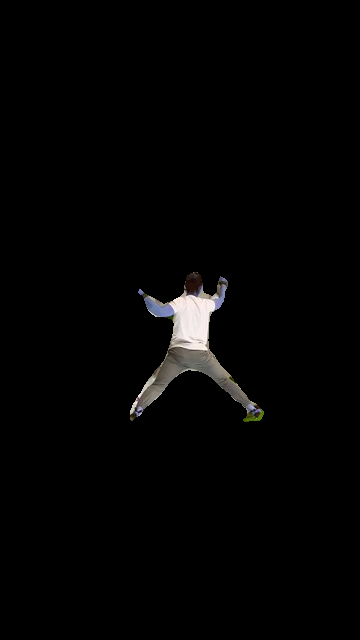

In [7]:
images = get_images_from_folder('/content/')
segmentations = get_segmentations(images)

plt.imshow(images[0])
plt.show()
plt.imshow(segmentations[0])
plt.show()

masked = mask_image(images[0], segmentations[0])
cv2_imshow(masked)

In [ ]:
images = get_images_from_video('/content/Straight Wall (vertical).mp4')
segmentations = get_segmentations(images)
masked_images = [mask_image(img, seg) for img, seg in zip(images, segmentations)]

 41%|████      | 1089/2669 [2:14:30<3:17:47,  7.51s/it]

In [ ]:
store_video_from_images(masked_images, 'masked_video')

from google.colab import files
files.download('/content/masked_video.mp4')